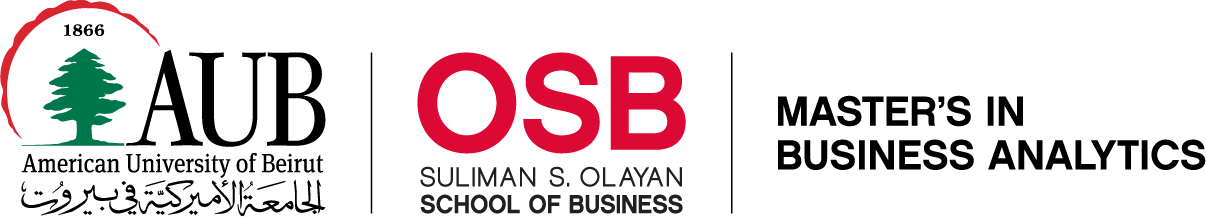
## Done by: Ali Maatouk 

# DATA SET CONTENT 
This data set contains booking information for a city hotel and a resort hotel, and includes information such as when the booking was made, length of stay, the number of adults, children, and/or babies, and the number of available parking spaces, among other things.

# Importing the required libraries

In [ ]:
#to speed up SVM and KNN
!pip install scikit-learn-intelex

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score 

from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

#Loading the csv data set into Pandas data frame from Google Drive 

In [ ]:
#Loading the data
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/hotel_bookings (1).csv"
df = pd.read_csv(path, index_col = False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part 1: Exploratory Data Analysis (EDA)

Report the most relevant insights that might be useful to improve the AUC performance of the predictive model.

## Viewing the Data Head

In [ ]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,01/07/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,01/07/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,02/07/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,02/07/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,03/07/2015


## Data Shape

In [ ]:
print("This data set has {} features and {} records".format(df.shape[1], df.shape[0]))

This data set has 31 features and 119390 records


## DataFrame Info

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

## Categorical Variables

In [ ]:
#Exploring categorical columns
catt_vars = df.select_dtypes(include=['object']).columns.tolist()

for i in df[catt_vars].columns:
    print("For variable ",i)
    print(df[i].value_counts())

In [ ]:
print('There are: {} categorical variables'.format(len(catt_vars)))

There are: 11 categorical variables


Noticed that some categorical columns have so many unique values so they might need feature engineering to assign all rare categories that are less than a specific frequency to one category

## Numeric Variables

A histogram is basically used to represent data provided in a form of some groups.It is accurate method for the graphical representation of numerical data distribution.It is a type of bar plot where X-axis represents the bin ranges while Y-axis gives information about frequency.

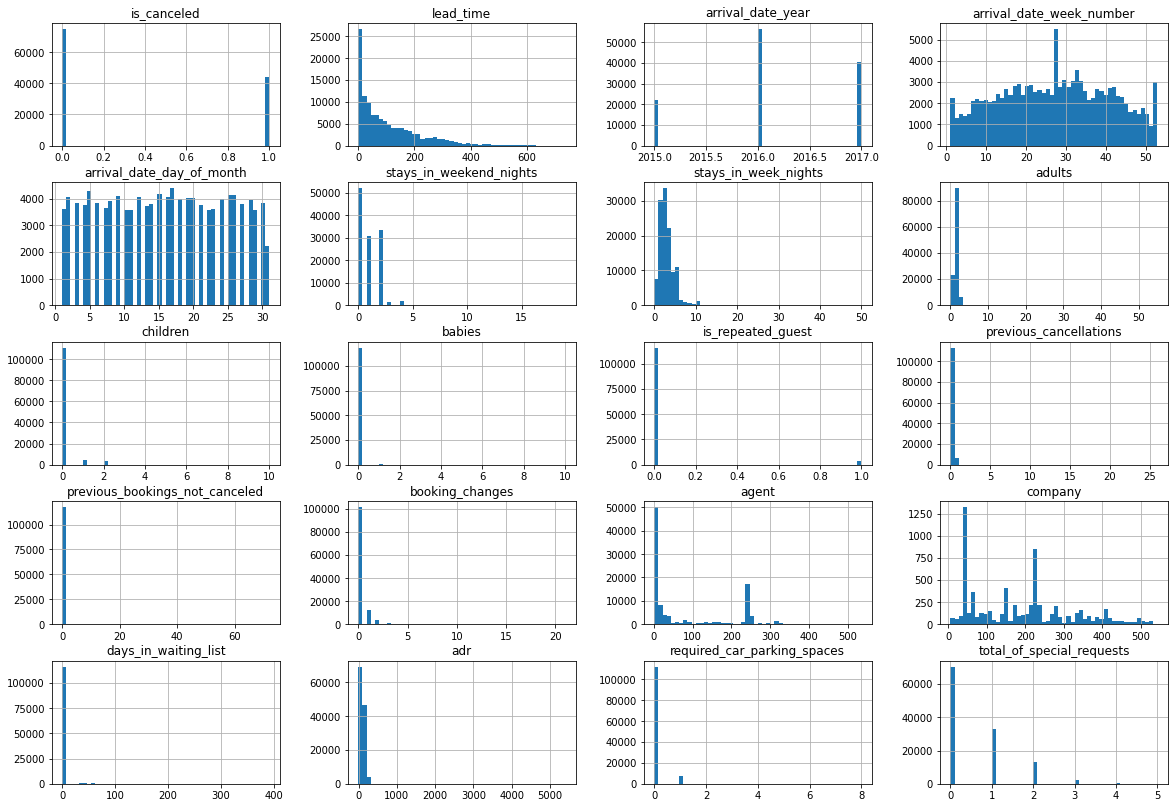

In [ ]:
#Exploring numerical columns
df.hist(bins = 50, figsize=(20,14))
plt.show()

From the histogram it can be deduced that days in waiting lists and lead time columns suffer from outliers. 

## DataFrame Summary Statistics

In [ ]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


## Change 'adr ' column name to 'Average Daily Rate' 

In [ ]:
df.rename(columns = {'adr':'average_daily_rate'}, inplace = True)

## Correlation Heat Map of Numerical Variables with the Target Variable

In [ ]:
corr_matrix = df.corr()

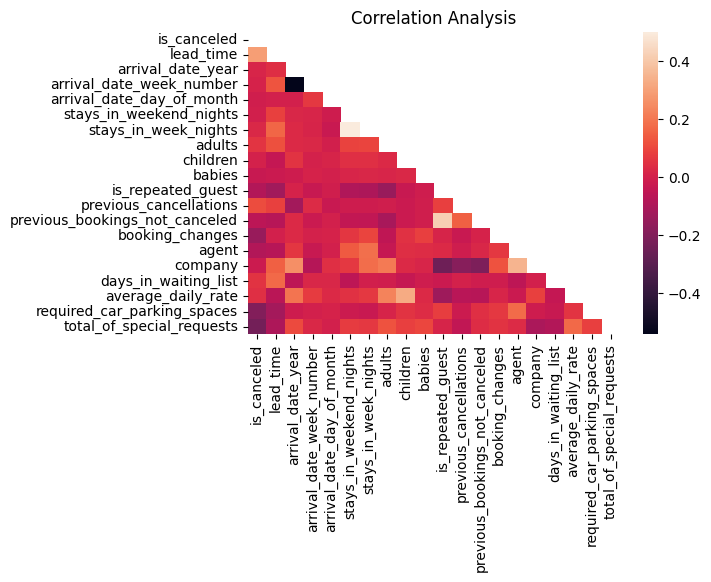

In [ ]:
mask = np.triu(np.ones_like(corr_matrix,dtype = bool))
plt.figure(dpi=100)
ax = plt.axes()
sns.heatmap(corr_matrix,annot=False, mask=mask,lw=0,linecolor='white',fmt = "0.2f")
plt.title('Correlation Analysis')
plt.axis('tight')
plt.show()

In [ ]:
#Correlation with the target
corr_matrix["is_canceled"].sort_values(ascending=False)

is_canceled                       1.000000
lead_time                         0.293123
previous_cancellations            0.110133
adults                            0.060017
days_in_waiting_list              0.054186
average_daily_rate                0.047557
stays_in_week_nights              0.024765
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
children                          0.005048
stays_in_weekend_nights          -0.001791
arrival_date_day_of_month        -0.006130
company                          -0.020642
babies                           -0.032491
previous_bookings_not_canceled   -0.057358
agent                            -0.083114
is_repeated_guest                -0.084793
booking_changes                  -0.144381
required_car_parking_spaces      -0.195498
total_of_special_requests        -0.234658
Name: is_canceled, dtype: float64

## Null Values

In [ ]:
print("The columns containing null values and their sum:")
df.isnull().sum().sort_values(ascending=False)[:4]

The columns containing null values and their sum:


company     112593
agent        16340
country        488
children         4
dtype: int64

## Number of Records for Each Hotel

First graph is about exploring hotel feature which denotes type of the hotels. According to the below graph, approximately 34% of the data was booked for resort hotel and the rest of was booked for City Hotel.

Text(0, 0.5, 'Count')

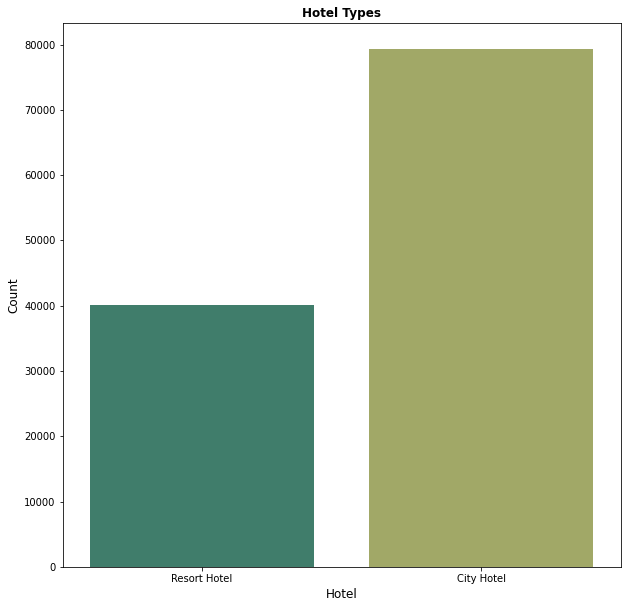

In [ ]:
# Hotel types details

plt.figure(figsize=(10,10))
sns.countplot(x='hotel', data = df, palette='gist_earth')
plt.title('Hotel Types', weight='bold')
plt.xlabel('Hotel', fontsize=12)
plt.ylabel('Count', fontsize=12)

## Target Value Exploration

Now, let's dive into the target value of data. The numbers are similar with hotel features. While 37% of booking canceled, 63% of booking is not canceled. These numbers also show that there is no balanced problem on the target value.

Text(0, 0.5, 'Canceled or Not Canceled')

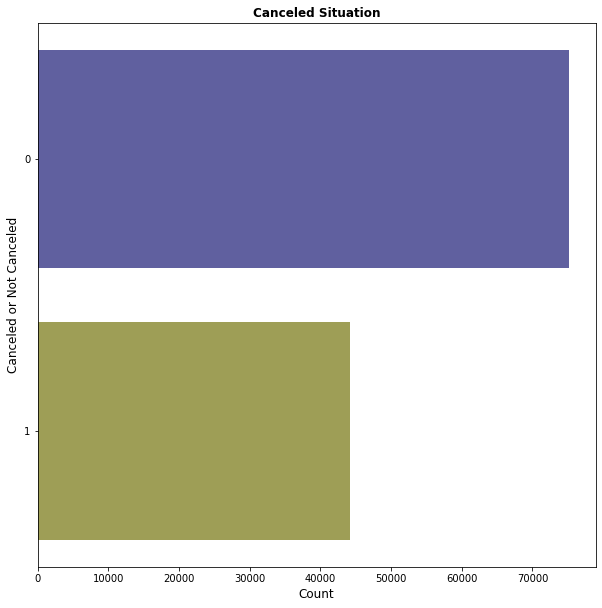

In [ ]:
# `is_canceled` graph

plt.figure(figsize=(10,10))
sns.countplot(y='is_canceled', data= df, palette='gist_stern', orient = 'v')
plt.title('Canceled Situation', weight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Canceled or Not Canceled', fontsize=12)

## Removing Zero Visitors rows

In [ ]:
# Some rows contain entreis with 0 adults, 0 children and 0 babies. 
# I'm dropping these entries with no guests.
zero_guests = list(df.loc[df["adults"]
                   + df["children"]
                   + df["babies"]==0].index)
df.drop(df.index[zero_guests], inplace=True)

# How much data is left?
print("the number of records dropped to:")
df.shape[0]

the number of records dropped to:


119210

# Part 2: Base Line System

Started with a baseline model and dropped some columns that seem to not have any predicting power or seem redundant like 'company', 'stays_in_weekend_nights', 'arrival_date_week_number', 'arrival_date_day_of_month' and so on

In [ ]:
X = df.drop(['company','stays_in_weekend_nights','arrival_date_week_number','arrival_date_day_of_month','children','is_canceled', 'arrival_date_year', 'babies', 'reservation_status_date', 'meal', 'previous_bookings_not_canceled', 'reserved_room_type'], axis=1)
y = df['is_canceled']

In [ ]:
num_vars = X.select_dtypes(include=['float', 'int']).columns.tolist()
cat_vars = X.select_dtypes(include=['object']).columns.tolist()

In [ ]:
#Defining categorical features and numerical features separately
X_cat = X[[c for c in X.columns if c in cat_vars]]
X_num = X[[c for c in X.columns if c in num_vars]]

In [ ]:
#splitting the data  into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle = True)

Did some basic preprocessing in order to train a Logistic regression model as a

baseline model

In [ ]:
# deal with missing values in categorical columns
# fill these with 'Missing'
def fill_cat_na(X):
    cat_vars_with_na = [col for col in X if (X[col].dtypes == "object") & (X[col].isna().sum() > 0)]
    for var in cat_vars_with_na:
        X[var] = X[var].fillna('Missing')
    return X
    
fill_cat = FunctionTransformer(fill_cat_na, validate=False)

In [ ]:
#Encoding categorical features with OneHotEncoding
cat_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore', drop = 'first')

In [ ]:
#Pipeline for categorical features
cat_pipeline = Pipeline([
        ('imputer', fill_cat),
        ('encoding', cat_encoder),
    ])

In [ ]:
#Pipeline to apply on all columns
full_pipeline = ColumnTransformer([
        ("cat", cat_pipeline, cat_vars)
    ])

In [ ]:
def display_scores(scores):
  print("Scores:", scores)
  print(f'Mean: {scores.mean():.3f}')
  print(f'Stdev: {scores.std():.3f}')

In [ ]:
#Logistic Regression Model
log_reg = LogisticRegression()

pipeline = Pipeline(steps=[('i', full_pipeline), ('m', log_reg)])
cv = KFold(n_splits=5, shuffle=True, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
display_scores(scores)

Scores: [0.82592957 0.82719382 0.82825906 0.82548843 0.82773338]
Mean: 0.827
Stdev: 0.001


This base line logistic regression system resulted with an AUC of 0.82 and standard devitation of 0.001. I have used 19 predictors for the base line model, and they were chosen based on the correlation ratio done in the EDA section, histograms, and based on common sense. 

# Part 3: Preprocessing

## Model after Removing Outliers & Imputing missing values

In [ ]:
#Defining lower and upper limits to detect outliers
def outliers(col):
    q1 = np.nanpercentile(col, 25)
    q3 = np.nanpercentile(col, 75)
    iqr = q3 - q1
    lower = q1 - (1.5 * iqr)
    upper = q3 + (1.5 * iqr)
    return lower , upper

In [ ]:
#Imputing missing values and outliers in the numerical columns with the median of each
from numpy import percentile
def impute_outliers_and_missing(X):
    num_vars = X.select_dtypes(include=['float', 'int']).columns.tolist() 
    for var in num_vars:
        median = X[var].median()
        X[var].fillna(median, inplace=True) 
        lower, upper = outliers(X[var])
        outliers_list = [x for x in X[var] if x < lower or x > upper]
        X[var][X[var].isin(outliers_list)] = median
    return X

outliers_and_missing_impute = FunctionTransformer(impute_outliers_and_missing, validate=False)

In [ ]:
#Pipeline for numerical features
num_pipeline = Pipeline([
        ('imputer', outliers_and_missing_impute)
      ])

In [ ]:
#Pipeline to apply on all columns
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_vars),
        ("cat", cat_pipeline, cat_vars),
    ])

In [ ]:
#Logistic Regression Model
log_reg = LogisticRegression()

pipeline = Pipeline(steps=[('i', full_pipeline), ('m', log_reg)])
cv = KFold(n_splits=5, shuffle=True, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
display_scores(scores)

Scores: [0.84990002 0.85486433 0.85664214 0.85472112 0.85512434]
Mean: 0.854
Stdev: 0.002


After removing outliers and imputing the missing values from numerical variables, the model's AUC increased from 0.82 to 0.85, and the standard deviation increased to 0.002

## Model After Scaling

In [ ]:
#Pipeline for numerical features
num_pipeline = Pipeline([
        ('imputer', outliers_and_missing_impute),
        ('scaler', StandardScaler())
      ])

In [ ]:
#Pipeline to apply on all columns
full_pipeline = ColumnTransformer(transformers=[
        ("num", num_pipeline, num_vars),
        ("cat", cat_pipeline, cat_vars)
    ])

In [ ]:
#Logistic Regression Model
log_reg = LogisticRegression()

pipeline = Pipeline(steps=[('i', full_pipeline), ('m', log_reg)])
cv = KFold(n_splits=5, shuffle=True, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
display_scores(scores)

Scores: [0.85914971 0.86292264 0.86548452 0.86255472 0.86176071]
Mean: 0.862
Stdev: 0.002


**After scaling the data, the AUC increased from 0.85 to 0.86 and standard deviation remained the same 0.002.**

**I tried normalizing the data, but the AUC decreased, so I stopped after scaling the data only.**

**So the applied preprocessing techniques include: One Hot Encoding, Outliers Removal, Imputing missing data, and scaling the data.**

## Testing the Model

In [ ]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('i',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   FunctionTransformer(func=<function impute_outliers_and_missing at 0x7f14cdf107a0>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['lead_time',
                                                   'stays_in_week_nights',
                                                   'adults',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'booking_changes', 'agent',
                                                   'days_in_waiting_list',
                       

In [ ]:
y_pred_proba = pipeline.predict_proba(X_test)[:,1]

In [ ]:
pipeline_roc_auc_score = roc_auc_score(y_test, y_pred_proba)
print('ROC AUC score of the Test Set: {:.3f} which is very close to the obtained score on the training set'.format(pipeline_roc_auc_score))

ROC AUC score of the Test Set: 0.861 which is very close to the obtained score on the training set


# Part 4: Feature Selection

## Logistic Regression Important Features

In [ ]:
#Finding the features importance of the baseline model
importance = abs(pipeline.named_steps['m'].coef_[0])
print("After Transformation the number of features of the base line model became: ",len(importance))

After Transformation the number of features of the base line model became:  222


In [ ]:
#Getting names of columns after all the transformations including OneHotEncoding
X_cat1 = X_cat.copy()
X_cat1= cat_pipeline.fit_transform(X_cat1)
cat_cols_ohe = list(cat_encoder.get_feature_names(input_features=cat_vars))
num_vars_list = list(X_num)
col_names = num_vars_list  + cat_cols_ohe 
#Sorting features based on importance and defining the top five features
feature_imp = pd.DataFrame(sorted(zip(importance, col_names)), columns=['Coef','Feature'])
features_df = feature_imp.sort_values(by="Coef", ascending=False)
features_df.head(25)

,Coef,Feature
221,4.895129,assigned_room_type_H
220,3.354097,assigned_room_type_E
219,2.342826,assigned_room_type_F
218,2.109224,country_ARE
217,1.799993,country_Missing
216,1.785711,country_AGO
215,1.669019,country_SGP
214,1.655173,country_NLD
213,1.537213,country_PAK
212,1.520906,country_HKG


## Feature Selection with RFECV

In [ ]:
#Feature selection with RFECV
from sklearn.feature_selection import RFECV

X_rfe = full_pipeline.fit_transform(X)
log_regr = LogisticRegression(random_state=1, n_jobs = -1)
rfecv = RFECV(estimator=log_regr, step=10, cv=5, scoring='roc_auc', n_jobs=-1)
rfecv.fit(X_rfe, y)
print(f"Average AUC score Uisng RFECV: {rfecv.score(X_rfe,y):.3f}")


Average AUC score Uisng RFECV: 0.786


In [ ]:
#number of features after RFECV
print("the number of features after RFECV became: {}".format(rfecv.n_features_))
print(f"the percentage reduction in feature size is: {100-((rfecv.n_features_/len(importance))*100) : .0f} %")

the number of features after RFECV became: 86
the percentage reduction in feature size is:  61 %


In [ ]:
#Sorting features based on importance and defining the top five features for the RFECV
rfecv_importance = abs(rfecv.estimator_.coef_[0])
rfecv_importance_actual = rfecv.estimator_.coef_[0]
rfecv_ranking = rfecv.ranking_
rfecv_feature_imp = pd.DataFrame(sorted(zip(rfecv_importance, rfecv_importance_actual, rfecv_ranking, col_names)), columns=['Coef', 'Actual Coef',
                                                                                                                            'Ranking', 'Feature'])
rfecv_features_df = rfecv_feature_imp.sort_values(by="Coef", ascending=True)
rfecv_features_df = rfecv_features_df[rfecv_features_df.Ranking == 1]
rfecv_features_df = rfecv_features_df.sort_values(by = "Coef", ascending=False)
rfecv_features_df

,Coef,Actual Coef,Ranking,Feature
85,4.825484,4.825484,1,country_GGY
84,3.651936,-3.651936,1,country_GBR
82,2.389202,-2.389202,1,country_GEO
76,1.583923,1.583923,1,country_BGR
74,1.452814,-1.452814,1,country_AZE
73,1.425903,1.425903,1,country_CHN
71,1.352355,1.352355,1,country_CPV
68,1.124688,1.124688,1,country_EST
67,1.121104,1.121104,1,country_CMR
63,1.018130,-1.018130,1,country_ALB


Using the RFECV technique The most powerful predictors are: Country, hotel, lead_time, total special requests. I only had 4 predictors with rank 1. 

<mark>Note: Although different countries have different importance, but since at least one country is signficant, then the whole "country" predictor is significant.</mark>

These Predictors make sense because:

1. **Lead time**, the higher the number of days that elapsed between the entering date of the booking into the PMS and the arrival date, the higher the chance of cancelation. 
2. **Total Special Requests**, it can be deduced that the higher the special requests made by a customer the less likely he/she cancels, because if the customer isn't serious about his booking, he wouldn't have made special requests. 
3. **Hotel**, the location of the hotel whether resort or city can affect the cancelation decision of the clients becuase of the different personas each hotel location attracts.Cancelation depends on the hotel location. Resort Hotel has more tendency of Cancelations.
4. **Country**, since the hotels are located in Portugal, then certain countries nationals may have to require visas before visiting, in case they were not granted a visa then their booking has to be canceled.



## Running the BaseLine Logistic Regression with a subset of features 

In [ ]:
#Defining the new Features Subset
X_subset = df[['lead_time', 'total_of_special_requests', 
               'booking_changes', 'hotel', 'country', 'assigned_room_type',
               'market_segment', 'distribution_channel', 'deposit_type']]

#Applying the Pipeline Steps manually on the subset
#dummy encoding
X_subset = pd.get_dummies(X_subset)

#imputing missing and outliers values
def impute_outliers_and_missingg(X_subset):
    num_vars = X_subset.select_dtypes(include=['float', 'int']).columns.tolist() 
    for var in num_vars:
        median = X_subset[var].median()
        X_subset[var].fillna(median, inplace=True) 
        lower, upper = outliers(X_subset[var])
        outliers_list = [x for x in X_subset[var] if x < lower or x > upper]
        X_subset[var][X_subset[var].isin(outliers_list)] = median
    return X_subset

impute_outliers_and_missingg(X_subset)

#Logistic Regression Model
log_reg = LogisticRegression()
#Defining a pipeline with Scaling step
standardize_pipe = Pipeline(steps=[('s', StandardScaler()), ('m', log_reg)])

cv = KFold(n_splits=5, shuffle=True, random_state=1)
# evaluate model
scores = cross_val_score(standardize_pipe, X_subset, y, scoring='roc_auc', cv=cv, n_jobs=-1)
display_scores(scores)

Scores: [0.85515221 0.85446254 0.85499875 0.85895825 0.85452722]
Mean: 0.856
Stdev: 0.002


The baseline model was further modified by decreasing the number of features from 19 to 8. Almost half of the features are dropped, so the baseline model was applied again with 57% less features than the first time. 

The AUC decreased from 0.86 to 0.85, but the drop is very negligible, and taking into consideration that is has 57% less features. 

The Feature subset above, was chosen based on the most important features from both RFECV and the Baseline model from part 3. So the features subset is a mix of both models. 

# Part 5: Model Optimization and Selection

## Feature Selection for the SVM & KNN

After several trials, to get a smoother and faster run time, I will drop the number of samples from 119 thousand to around 23 thousand (just 20% of the obeservaions).

Also the country column was dropped for having alone over 160 features after one hot encoding.

In [ ]:
# I will drop the country Feature that has over 160 features after encoding to reduce the running time 
X_subset_5 = df[['lead_time', 'total_of_special_requests', 
               'booking_changes', 'hotel','assigned_room_type',
               'market_segment', 'distribution_channel', 'deposit_type']]

In [ ]:
# For SVM and KNN models I will only use a subset of a the data samples for the sake of running time
X_5, X_test_5, y_5, y_test_5 = train_test_split(X_subset_5, y, test_size=0.8, random_state=1, shuffle = True, stratify=y)

I will preprocess the data manually instead of applying the pipeline. 
Plus for the distance based models, I added an extra step which is normalizing the data. 

In [ ]:
#Preprocessing the Subset

#dummy encoding
X_5 = pd.get_dummies(X_5)

#imputing missing and outliers values
def impute_outliers_and_missingg(X_5):
    num_vars = X_5.select_dtypes(include=['float', 'int']).columns.tolist() 
    for var in num_vars:
        median = X_5[var].median()
        X_5[var].fillna(median, inplace=True) 
        lower, upper = outliers(X_5[var])
        outliers_list = [x for x in X_5[var] if x < lower or x > upper]
        X_5[var][X_5[var].isin(outliers_list)] = median
    return X_5

impute_outliers_and_missingg(X_5)

#Normalize the Data
normalized_df = (X_5-X_5.min())/(X_5.max()-X_5.min())
X_5['lead_time'] = normalized_df['lead_time']
X_5.var()

standard_object = StandardScaler()
standard_object.fit_transform(X_5)

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Defining the model, then running it
k_range = range(1, 50, 2)
knn_roc_auc_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate model
    scores = cross_val_score(knn, X_5, y_5, scoring='roc_auc', cv=cv, n_jobs=-1)
    knn_roc_auc_scores.append(scores.mean())

<mark>**Note**: the run time of this KNN for loop took less than a minute 

Text(0, 0.5, 'ROC AUC Score')

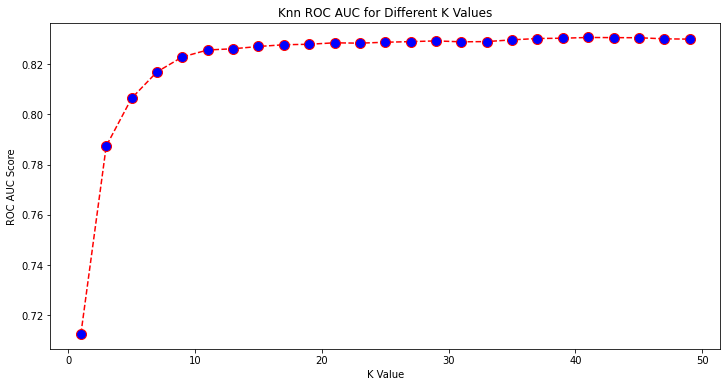

In [ ]:
# displaying the AUC for every neighbor
plt.figure(figsize=(12, 6))
plt.plot(k_range, knn_roc_auc_scores, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Knn ROC AUC for Different K Values')
plt.xlabel('K Value')
plt.ylabel('ROC AUC Score')

**Interpretation:** The KNN calisfier reached the maximum point at k = 41, and between k = 11 and k = 50 the classifier made almost the same performance. 

In [ ]:
# What is the Best K and its corresponding AUC?

knn_roc_auc_scores = np.array(knn_roc_auc_scores)
best_knn_score = knn_roc_auc_scores[knn_roc_auc_scores.argmax()]
best_k = k_range[knn_roc_auc_scores.argmax()]

print(f'Best K={best_k} achieved a ROC AUC = {best_knn_score :.4f}')


Best K=41 achieved a ROC AUC = 0.8306


In [ ]:
#Best KNN Model
knn = KNeighborsClassifier(n_neighbors=41)
cv = KFold(n_splits=5, shuffle=True, random_state=1)
# evaluate model
scores = cross_val_score(knn, X_5, y_5, scoring='roc_auc', cv=cv, n_jobs=-1)
display_scores(scores)

Scores: [0.83595209 0.84201501 0.82216658 0.82726646 0.82563232]
Mean: 0.831
Stdev: 0.007


In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)
classifier = KNeighborsClassifier(n_neighbors=41)

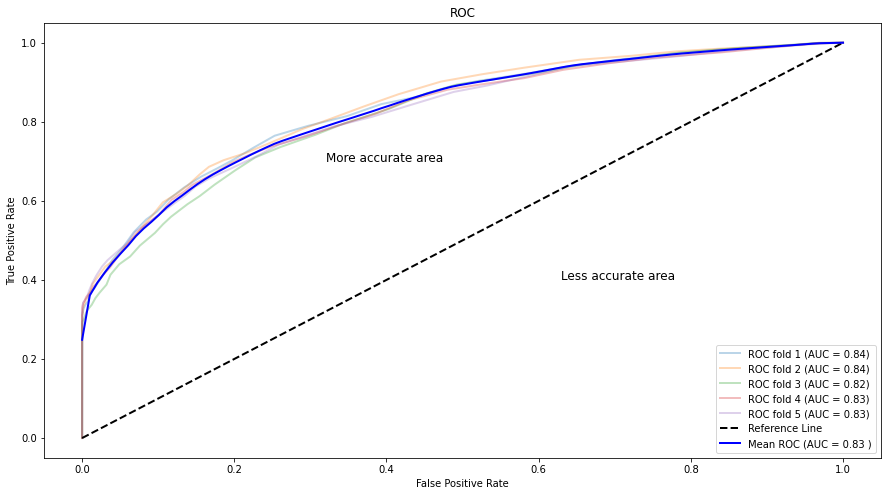

In [ ]:
from sklearn.metrics import roc_curve, auc

# Creating Figure
fig = plt.figure(figsize=(15,8))
tprs = []
aucs = []
# Create fpr (x-axis) evenly spaced numbers of interval 0.01 from 0 to 1
mean_fpr = np.linspace(0,1,100)
# Counter for folds
i = 1
# Splitting the cross-validated data of each fold
for train,test in cv.split(X_5):
  # Fit the KNN Model and predict the probabilites
  classifier.fit(X_5.iloc[train], y_5.iloc[train])              
  prediction = classifier.predict_proba(X_5.iloc[test])
  # Get the FPR, TPR and Threshold
  fpr, tpr, t = roc_curve(y_5.iloc[test], prediction[:,1])
  # Linear Interpolation
  tprs.append(np.interp(mean_fpr, fpr, tpr))
  # Get the auc score
  roc_auc = auc(fpr, tpr)
  aucs.append(roc_auc)
  # Plot the points
  plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
  i= i+1
# Plotting the Reference Line
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black',label='Reference Line')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

**Interpretation**:

The above roc curve shows that the AUC of the best knn model folds are roughly the same. 

The variation is minimal. 

I can conclude that this model is stable.

## SVM

In [ ]:
from sklearn.svm import SVC

<mark> After many trials in emplementing the an SVC model with RBF kernel, the runtime kept diconnecting after hours of running.

The linear kernal was used instead, which meant that there was no need for the gamma paramater. 



In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)
c_range = [0.001,0.01,0.1,1,10,100]
svcscores = []

for c in c_range:
  svc = SVC(C=c, kernel='linear')
  auc_score = cross_val_score(svc, X_5, y_5, cv=cv, n_jobs=-1, scoring='roc_auc')
  svcscores.append([auc_score, c])

for score in range(len(svcscores)):
  print(f'The model achieved a ROC AUC OF {svcscores[score][0].mean():.3f} when C was {svcscores[score][1]}')

The model achieved a ROC AUC OF 0.792 when C was 0.001
The model achieved a ROC AUC OF 0.764 when C was 0.01
The model achieved a ROC AUC OF 0.754 when C was 0.1
The model achieved a ROC AUC OF 0.759 when C was 1
The model achieved a ROC AUC OF 0.758 when C was 10
The model achieved a ROC AUC OF 0.741 when C was 100


<mark> This SVM for loop took around 3 minutes to Run 

In [ ]:
#finding the best paramaters
svc_avg_scores = []
svc_best_params = []
for score in range(len(svcscores)):
  svc_avg_scores.append(svcscores[score][0].mean())
  if svcscores[score][0].mean() == max(svc_avg_scores):
    svc_best_params.append([svcscores[score][0].mean(), svcscores[score][1]])

In [ ]:
print(f'The best SVC model paramter is the C value of {svc_best_params[0][1]} that yielded an AUC of {svc_best_params[0][0]:0.3f}')

The best SVC model paramter is the C value of 0.001 that yielded an AUC of 0.792


In [ ]:
#Best SVC Model
best_svc = SVC(kernel='linear', C=0.001)
cv = KFold(n_splits=5, shuffle=True, random_state=1)
# evaluate model
best_svc_scores = cross_val_score(best_svc, X_5, y_5, scoring='roc_auc', cv=cv, n_jobs=-1)
display_scores(best_svc_scores)

Scores: [0.79435148 0.79342082 0.78744429 0.79104787 0.794432  ]
Mean: 0.792
Stdev: 0.003


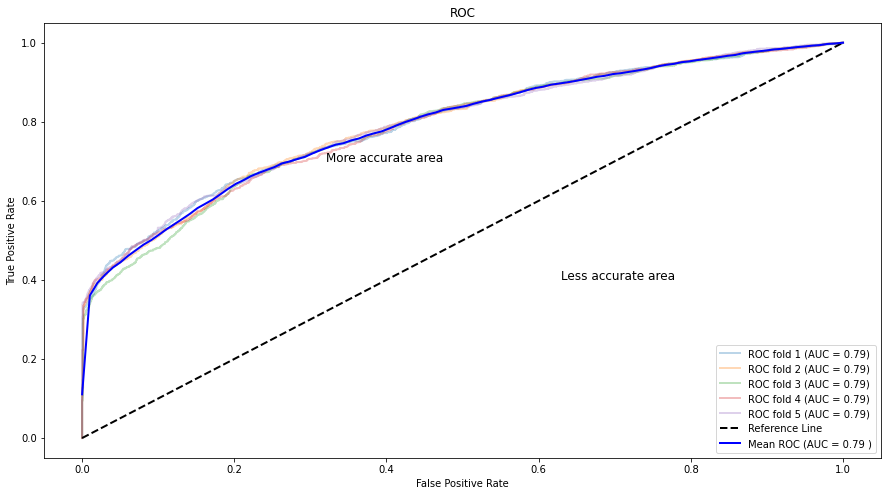

In [ ]:
from sklearn import metrics
# The best Model
cv = KFold(n_splits=5, shuffle=True, random_state=1)
svc_classifier = SVC(kernel='linear', C=0.001, probability=True)

# Creating Figure
fig = plt.figure(figsize=(15,8))
tprs = []
aucs = []
# Create fpr (x-axis) evenly spaced numbers of interval 0.01 from 0 to 1
mean_fpr = np.linspace(0,1,100)
# Counter for folds
i = 1
# Splitting the cross-validated data of each fold
for train,test in cv.split(X_5):
  # Fit the SVC Model and predict the probabilites
  svc_classifier.fit(X_5.iloc[train], y_5.iloc[train])              
  prediction = svc_classifier.predict_proba(X_5.iloc[test])
  # Get the FPR, TPR and Threshold
  fpr, tpr, t = roc_curve(y_5.iloc[test], prediction[:,1])
  # Linear Interpolation
  tprs.append(np.interp(mean_fpr, fpr, tpr))
  # Get the auc score
  roc_auc = metrics.auc(fpr, tpr)
  aucs.append(roc_auc)
  # Plot the points
  plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
  i= i+1
# Plotting the Reference Line
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black',label='Reference Line')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

**Interpretation**:

The above roc curve shows that the AUC of the best knn model folds are roughly the same. 

The variation is minimal. 

I can conclude that this model is stable.

## Part 6: Model Optimization and Selection

## Which preprocessing techniques, features, and model do you select for deployment (operation)?

For deployement I will choose the model according to the runtime speed, then the model's complexity, and finally the model's AUC score. 

So based on the criteria mentioned above, the final baseline model done in the last section of part 4 fits this criteria perfectly. 

The model features', and the preprocessing steps made on them yielded satisfactory a result. 

## What recommendations do you provide?

1. I would recommend the hotel management to work on reducing the lead time for bookings, it is probably a problem of late data entry to the hotel booking management system. 

2. The hotel management can choose to remove or include the "Country" feature from its model, if it finds it against its Anti Descrimination policey. The country feature could be considered by some managers to be a racial bias or descrimination. 

3. The city hotel should consider further investigation about why would its location increase the chances of Cancelation. This issue needs domain knowledge and more data to be solved. 

4. Encouraging clients to make special requests, leads to less cancelation. The management can figure out a marketing scheme that leads clients to make more special requests to personalize their stay at the hotel, which results in a feeling of inclusivity and comfort. 

## If your boss gives you an extra month to further improve this project, what would you do?

1. I would further inspect the features and try different sub features with several models to enhance my final model even further.

2. I would try applying models not mentioned in the task description like probabilistic models and tree based models. 

3. I would definitley ask my boss to buy me colab pro+ subscription to facilitate my experience while trying to run complex codes. 😋

4. I would try further preprocess the data, like biining the categorical features. 

# Downloading the Notebook as HTML

In [ ]:
%%shell
jupyter nbconvert --to html ////content/ahm44_Ali_Maatouk_assign3.ipynb

[NbConvertApp] Converting notebook ////content/ahm44_Ali_Maatouk_assign3.ipynb to html
[NbConvertApp] ERROR | Notebook JSON is invalid: Additional properties are not allowed ('metadata' was unexpected)

Failed validating 'additionalProperties' in stream:

On instance['cells'][107]['outputs'][0]:
{'metadata': {'tags': None},
 'name': 'stdout',
 'output_type': 'stream',
 'text': 'The model achieved a ROC AUC OF 0.792 when C was 0.001\n'
         'The model...'}
[NbConvertApp] Writing 874263 bytes to ////content/ahm44_Ali_Maatouk_assign3.html
